In [1]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [2]:
data = pd.read_excel('data/data.xlsx')

## Data cleaning and feature selection

In [3]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [4]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [5]:
data_macro = data.copy()

---

In [6]:
# Creating a target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    2646
1     543
Name: cmltv_90_bad, dtype: int64


In [7]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'type_of_product',
    'employment_level',
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [8]:
data_macro.isna().sum()

client_id                                                        0
loan_currency                                                    0
loan_amount                                                      0
date_of_disbursement                                             0
date_of_closure_based_on_contract                                0
duration_at_disbursement_months                                  0
interest_rate                                                    0
max_dpd_3_year                                                   0
cumulative_days_of_late_payments_throughout_loan_repayments      0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
type_of_product                                                  0
status_of_loan                                                   0
location                                                         0
emirates                                                         0
gender                                                        

In [9]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [10]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN


In [11]:
data_na = data_macro.dropna(subset=cat_feats+num_feats)

---

In [10]:
data_na['presence_of_car_binary'] = data_na['presence_of_car'].copy()
data_na['presence_of_car_binary'].replace({2: 1, 3: 1, 4: 1, 5: 1, 6: 1}, inplace=True)

In [143]:
data_na['presence_of_housing_binary'] = data_na['presence_of_housing'].copy()
data_na['presence_of_housing'].replace({2: 1, 3: 1, 4: 1, 5: 1, 6: 1}, inplace=True)

In [179]:
ignore_feats.extend(['presence_of_housing_binary', 'presence_of_car_binary'])

---

In [12]:
stats = data_na[target].groupby(data_na['type_of_product']).agg(['count', 'mean'])

In [13]:
stats

,count,mean
type_of_product,,
CAR LOAN,48,0.083333
HOUSING LOAN,218,0.041284
PERSONAL LOAN,2680,0.197388


In [16]:
stats_empl = data_na[target].groupby(data_na['employment_level']).agg(['count', 'mean'])

In [17]:
stats_empl.reset_index(inplace=True)

In [18]:
data_na['type_of_product_mean_encoded'] = data_na['type_of_product']

In [19]:
data_na['type_of_product_mean_encoded'].replace(
    {
        'CAR LOAN': stats.loc['CAR LOAN', 'mean'], 
        'HOUSING LOAN': stats.loc['HOUSING LOAN', 'mean'], 
        'PERSONAL LOAN': stats.loc['PERSONAL LOAN', 'mean'], 
    }, 
    inplace=True
)

In [20]:
data_na['employment_level_mean_encoded'] = data_na['employment_level']

In [21]:
for index, row in stats_empl.iterrows():
    data_na.loc[data_na['employment_level'] == row['employment_level'], 'employment_level_mean_encoded'] = row['mean']

In [22]:
# Add new derived features to the feature list
num_feats.extend(['type_of_product_mean_encoded', 'employment_level_mean_encoded'])

---

In [23]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_na[(data_na['status_of_loan'] == 'Active') & (data_na[target] == 1) | (data_na['status_of_loan'] != 'Active')]

In [24]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(data_closed_or_bad.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns :
            print(i)

All variables are found in feature lists


In [25]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(data_closed_or_bad.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

True

# Modeling
---

In [26]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [30]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False,
    
    session_id=19,
    html=False
)

                    Description             Value
0                    Session id                19
1                        Target      cmltv_90_bad
2                   Target type            Binary
3           Original data shape        (2691, 35)
4        Transformed data shape        (2691, 35)
5   Transformed train set shape        (2152, 35)
6    Transformed test set shape         (539, 35)
7               Ignore features                14
8              Ordinal features                 2
9              Numeric features                14
10         Categorical features                 6
11     Rows with missing values              1.7%
12                   Preprocess              True
13              Imputation type            simple
14           Numeric imputation              mean
15       Categorical imputation              mode
16     Maximum one-hot encoding                25
17              Encoding method              None
18     Remove multicollinearity              True


In [28]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.01,
    fold=5
)

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8051  0.8204  0.2299  0.5405  0.3226  0.2298  0.2586
1       0.8376  0.8154  0.2989  0.7429  0.4262  0.3511  0.4007
2       0.8186  0.7593  0.2442  0.6176  0.3500  0.2669  0.3059
3       0.8395  0.8457  0.3256  0.7179  0.4480  0.3693  0.4090
4       0.8302  0.7991  0.2989  0.6842  0.4160  0.3341  0.3735
Mean    0.8262  0.8080  0.2795  0.6606  0.3926  0.3102  0.3495
Std     0.0129  0.0286  0.0363  0.0733  0.0479  0.0530  0.0581


In [33]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

                 Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  CatBoost Classifier    0.8256  0.8007  0.2477  0.6923  0.3649  0.2891   

      MCC  
0  0.3408  
{'0': {'precision': 0.8705882352941177,
       'recall': 0.8604651162790697,
       'f1-score': 0.8654970760233918,
       'support': 430},
 '1': {'precision': 0.47368421052631576,
       'recall': 0.4954128440366973,
       'f1-score': 0.48430493273542596,
       'support': 109},
 'accuracy': 0.7866419294990723,
 'macro avg': {'precision': 0.6721362229102167,
               'recall': 0.6779389801578835,
               'f1-score': 0.6749010043794088,
               'support': 539},
 'weighted avg': {'precision': 0.790323785016399,
                  'recall': 0.7866419294990723,
                  'f1-score': 0.7884099821117253,
                  'support': 539},
 'threshold': 0.25,
 'TN': 370,
 'FP': 60,
 'FN': 55,
 'TP': 54,
 'AUC': 0.8007,
 'model NPL': 12.94,
 ' real NPL': 20.22,
 'approval rate': 78.85,
 'goo

In [32]:
list(exp.get_config('variables'))

['X_test',
 'gpu_n_jobs_param',
 'y_train_transformed',
 'dataset',
 'y_train',
 'dataset_transformed',
 'USI',
 'X_test_transformed',
 'test',
 'idx',
 'logging_param',
 'y_test',
 'y',
 'fix_imbalance',
 'fold_groups_param',
 'seed',
 '_ml_usecase',
 'data',
 'fold_shuffle_param',
 'pipeline',
 'variable_and_property_keys',
 'exp_name_log',
 'y_test_transformed',
 'html_param',
 'memory',
 'exp_id',
 'X_train',
 'log_plots_param',
 'test_transformed',
 'target_param',
 'is_multiclass',
 'y_transformed',
 '_available_plots',
 'n_jobs_param',
 'X_transformed',
 'train_transformed',
 'train',
 'fold_generator',
 'X_train_transformed',
 'gpu_param',
 'X']

In [65]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8256,0.8007,0.2477,0.6923,0.3649,0.2891,0.3408


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.610390,0.800683,232.0,198.0,12.0,97.0
1,0.15,0.686456,0.800683,289.0,141.0,28.0,81.0
2,0.20,0.736549,0.800683,328.0,102.0,40.0,69.0
3,0.25,0.786642,0.800683,370.0,60.0,55.0,54.0
4,0.30,0.810761,0.800683,391.0,39.0,63.0,46.0


In [89]:
test_set = exp.get_config('test')
test_set[target].value_counts()

0    432
1    107
Name: cmltv_90_bad, dtype: int64

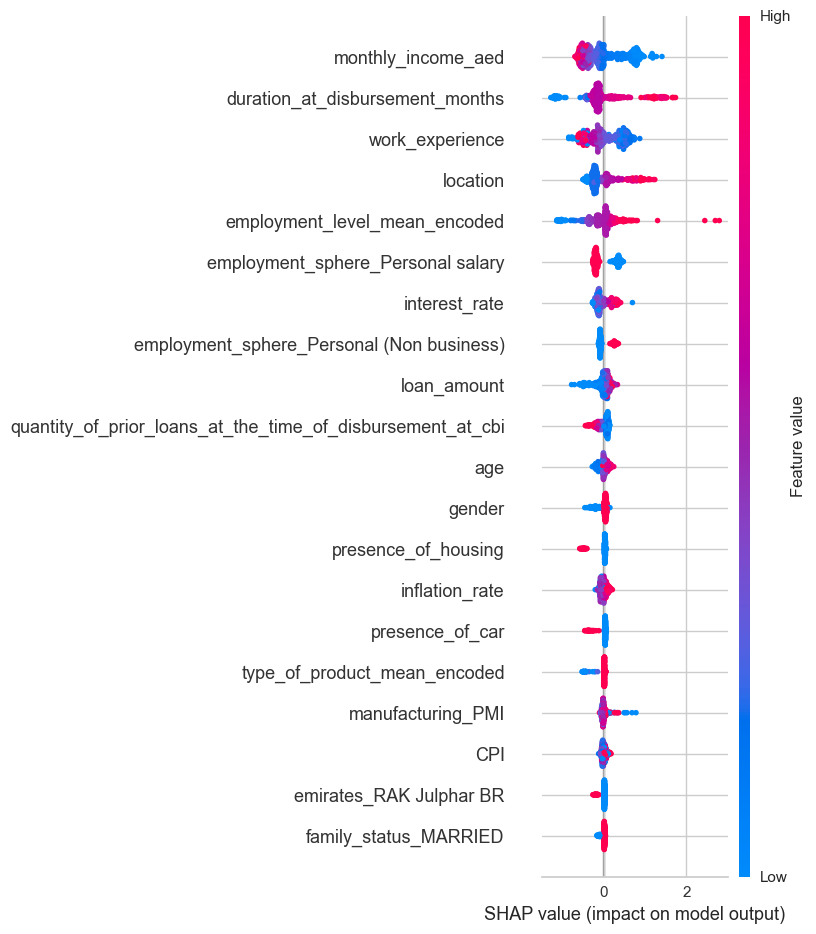

In [35]:
exp.interpret_model(trained_model_catboost)

In [29]:
exp.evaluate_model(trained_model_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

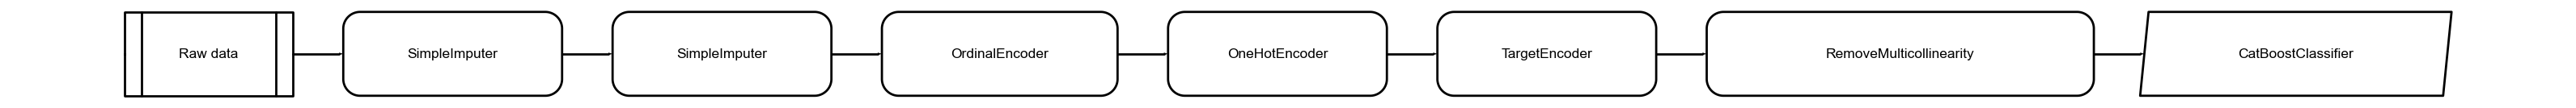

In [30]:
exp.plot_model(trained_model_catboost, plot='pipeline' )

In [116]:
predictions = exp.predict_model(trained_model_catboost, raw_score=True, encoded_labels=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8130,0.7994,0.3000,0.5789,0.3952,0.2975,0.3201


In [117]:
# final = test.copy()
final['prediction_6'] = list(predictions['prediction_score_0'])

In [118]:
final

,client_id,loan_currency,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,...,inflation_rate,manufacturing_PMI,CPI,IsBad_30,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6
1826,9765,AED,150000.0,2021-09-01,2025-08-11,48,0.0800,0,0,0,...,1.2,53.3,107.21,0.0,0.9548,0.9999,0.8716,1.0000,0.8862,1.0000
1709,6024,AED,175000.0,2021-03-07,2024-05-27,39,0.0650,0,0,4,...,-1.1,52.6,105.75,0.0,0.9993,0.9940,0.9986,0.9901,0.9994,0.9931
1593,5879,AED,262000.0,2017-08-09,2021-08-02,48,0.0775,0,0,4,...,0.8,57.3,107.46,0.0,0.9690,0.9980,0.9692,0.9978,0.9429,0.9980
1299,5534,AED,750000.0,2018-05-07,2022-04-29,48,0.0500,0,0,6,...,3.5,56.5,111.08,0.0,0.9975,1.0000,0.9935,1.0000,0.9953,1.0000
1718,6034,AED,300000.0,2017-08-15,2021-07-27,48,0.0700,0,0,5,...,0.8,57.3,107.46,0.0,0.9903,0.9806,0.9969,0.9940,0.9951,0.9922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,5712,AED,750000.0,2018-10-07,2022-09-29,48,0.0625,0,0,4,...,1.6,55.0,110.40,0.0,0.9816,0.0945,0.9737,0.6799,0.9959,0.6132
1233,5463,AED,370000.0,2017-08-08,2021-08-30,49,0.0600,0,0,6,...,0.8,57.3,107.46,0.0,0.9000,0.6030,0.8774,0.9489,0.7603,0.9079
1578,5862,AED,600000.0,2018-08-06,2022-08-29,49,0.0600,0,0,5,...,3.9,55.0,111.60,0.0,0.9906,1.0000,0.9917,1.0000,0.9946,1.0000
1424,5677,AED,150000.0,2017-08-02,2022-02-10,55,0.0625,0,0,1,...,0.8,57.3,107.46,0.0,0.0074,0.9755,0.1293,0.9847,0.0246,0.9932


In [119]:
final.to_excel('results.xlsx',index=False)